# Initialisation du notebook

L'objectif du module est de développer un système de suggestion de tag pour le site Stack Overflow. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

Ce notebook se consacre à l'exploration et nettoyage des données. 

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold=10

<IPython.core.display.Javascript object>

In [2]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os, pickle, warnings
import datetime as dt
from sklearn.utils import resample
import re, nltk, spacy, gensim
from bs4 import BeautifulSoup
from spacy.lang.en import English
from nltk.corpus import stopwords
from string import punctuation

# Déclaration de variables 

data_path = r"C:\OCR\06 _ Catégorisez automatiquement des questions"
   
pd.options.mode.chained_assignment = None # default='warn'
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format
warnings.filterwarnings("ignore")

colors = ['#911eb4', '#f032e6', '0', '#e6beff', '#e6194b', '#fabebe', '#f58231', '#ffe119', 
          '#fffac8', '#bfef45', '#3cb44b', '#aaffc3', '#469990', '#42d4f4', '#4363d8']

# Chargement et découverte des données brutes

In [3]:
all_files = glob.glob(os.path.join(data_path, "QueryResults*.csv")) 

li = []

for absolute_filename in all_files:
    path, file = os.path.split(absolute_filename)
    df = pd.read_csv(absolute_filename, sep=',', encoding='utf-8', engine='python', error_bad_lines=False)
    li.append(df)

df_brut = pd.concat(li, axis=0, ignore_index=True)

print('Taille du CSV importé : {0}'.format(df_brut.shape))

print(pd.DataFrame(df_brut.dtypes, columns=['Type']))

Taille du CSV importé : (91947, 6)
         Type
Id      int64
Name   object
Score   int64
Body   object
Title  object
Tags   object


In [4]:
df_brut.to_pickle("./df_brut.pkl")

Les données extraites ciblent uniquement les posts de type "Question" dont les Id sont compris entre 0 et 600000.

In [3]:
df_brut = pd.read_pickle('./df_brut.pkl')

# Pandas Profiling

In [20]:
profile = df_brut.profile_report(title='Pandas Profiling Report', style={'full_width':True})
profile.to_file(output_file="output.html")

Aucune valeur manquante dans BODY, TITLE et TAGS

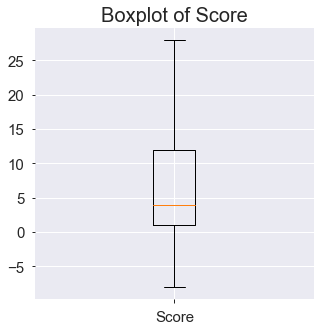

In [21]:
# Boxplot of the variable Score

plt.figure(figsize=(5, 5))
plt.title("Boxplot of Score", fontsize=20)

# Boxplot without showing the outliers 
plt.xticks(size=15)
plt.yticks(size=15)
plot = plt.boxplot(df_brut["Score"], showfliers=False, labels=['Score'])

plt.show()

In [4]:
posts_tags = df_brut[df_brut.Score >= 3]['Tags']
posts_body = df_brut[df_brut.Score >= 3]['Body']
print("Nombre de posts :", posts_tags.shape[0])

Nombre de posts : 55598


# Analyse de la variable TAGS

In [5]:
posts_tags.head(5)

0    <c#><floating-point><type-conversion><double><decimal>
1    <html><css><internet-explorer-7>                      
2    <c#><.net><datetime>                                  
3    <c#><datetime><time><datediff><relative-time-span>    
4    <html><browser><timezone><user-agent><timezone-offset>
Name: Tags, dtype: object

In [6]:
# création d'un ensemble contenant tous les tags à partir des données du dataframe
# l'avantage d'un ensemble, c'est qu'un élément ne peut s'y trouver que 0 ou 1 fois 

set_tags = set() 

for list_keywords in (posts_tags.str.split('>').values):       
    # je rétablis le séparateur utilisé pour séparer les tags
    list_keywords.remove('')
    list_keywords = [keyword[1:] for keyword in list_keywords] 
    set_tags = set_tags.union(list_keywords)

print('There are %d tags' % len(set_tags))

There are 9712 tags


In [7]:
print(sorted(set_tags)[1750:1800])
# D est un langage de programmation

['currying', 'curses', 'cursor', 'cursor-position', 'cursor.current', 'cursors', 'curve', 'curve-fitting', 'curvesmoothing', 'custom-action', 'custom-attributes', 'custom-build-step', 'custom-component', 'custom-controls', 'custom-cursor', 'custom-draw', 'custom-error-pages', 'custom-errors', 'custom-exceptions', 'custom-linq-providers', 'custom-object', 'custom-protocol', 'custom-sections', 'custom-server-controls', 'custom-url-protocol', 'customization', 'custompaging', 'customtool', 'customvalidator', 'cut', 'cvs', 'cwd', 'cx-oracle', 'cxf', 'cycle', 'cyclic-reference', 'cyclomatic-complexity', 'cygwin', 'cython', 'd', 'd-star', 'daab', 'dabo', 'daemon', 'dailybuilds', 'dalvik', 'dao', 'darcs', 'darwin', 'dasblog']


In [8]:
print(sorted(set_tags)[5500:5600])
# nt = windows nt

['nod32', 'node.js', 'nodebox', 'nodelist', 'nodes', 'nodesets', 'nodester', 'nodevalue', 'nofollow', 'nohup', 'nokia', 'nomenclature', 'non-clustered-index', 'non-deterministic', 'non-greedy', 'non-lazy-ptr', 'non-nullable', 'non-printable', 'non-printing-characters', 'non-recursive', 'non-relational-database', 'non-scrolling', 'non-static', 'non-virtual-interface', 'non-well-formed', 'nonatomic', 'nonblank', 'nonblocking', 'nonclient', 'nonlinear-functions', 'normal-distribution', 'normalization', 'normalize', 'normalizing', 'noscript', 'nose', 'nosql', 'nosuchmethoderror', 'not-exists', 'not-operator', 'notation', 'notepad', 'notepad++', 'nothing', 'notification-bar', 'notifications', 'notify', 'notifyicon', 'notimplementedexception', 'notin', 'notnull', 'notsupportedexception', 'novell', 'novell-idm', 'noweb', 'np-complete', 'np-hard', 'npapi', 'nptl', 'nrpe', 'nsarray', 'nsarraycontroller', 'nsautoreleasepool', 'nscell', 'nscoding', 'nsdata', 'nsdate', 'nsdateformatter', 'nsdecima

In [9]:
posts_tags.loc[posts_tags.str.contains('<d>')].head(10)

5145     <d>                                                                
9336     <memory><memory-management><d><garbage-collection>                 
15091    <multithreading><performance><d><thread-local-storage>             
18400    <c><performance><d><standard-library>                              
20945    <.net><interop><d>                                                 
24157    <arrays><d><dmd>                                                   
28225    <performance><multithreading><optimization><parallel-processing><d>
32839    <d><popularity>                                                    
36866    <editor><d>                                                        
37683    <input><d><tango>                                                  
Name: Tags, dtype: object

In [10]:
# je compte les occurrences de chaque tag dans le dataframe
alltags_count = dict()
for s in set_tags: 
    #print(s)
    alltags_count[s] = posts_tags.str.count(re.escape(s)).sum() 

In [11]:
alltags_count = sorted(alltags_count.items(), key=lambda x: x[1], reverse=True)

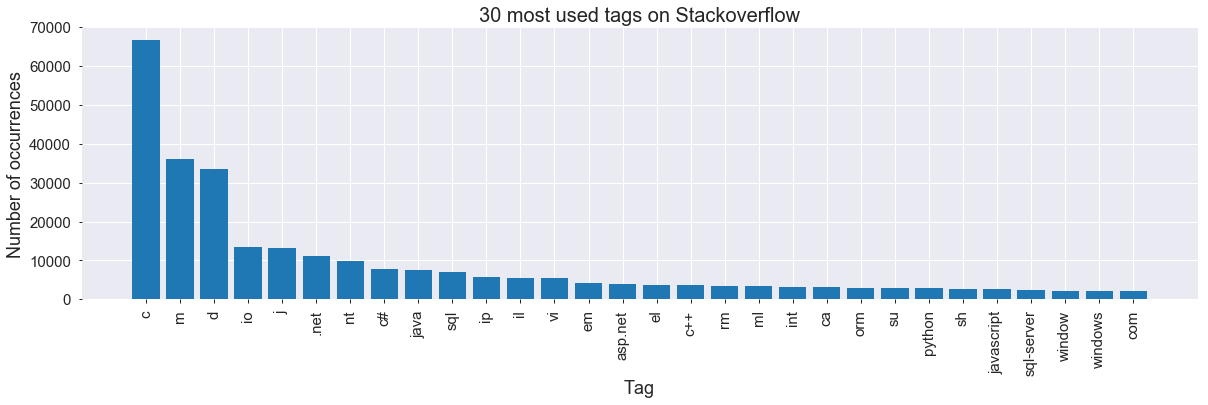

In [12]:
# Graphique des 30 tags les plus utilisés sur Stackoverflow

top30tags = alltags_count[1:31]

plt.figure(figsize=(20, 5))
y_axis = [i[1] for i in top30tags]
label_x = [i[0] for i in top30tags]
ax = plt.axes()
plt.bar(label_x, y_axis)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.title("30 most used tags on Stackoverflow",fontsize=20)
plt.xlabel('Tag', fontsize=18)
plt.ylabel('Number of occurrences', fontsize=18)
plt.show()

### Nombre de posts impactés par les 100 à 1000 premiers tags

In [13]:
nb_posts_targeted = dict() 

for nb_top_tags in np.linspace(100, 1000, 10, dtype='int'):

    top_tags = [i[0] for i in alltags_count[1:nb_top_tags+1]]
    nb_posts_targeted[nb_top_tags] = 0
    
    for _tags in posts_tags.str.split('>'):
        _tags.remove('')
        _tags = [_tag[1:] for _tag in _tags] 
        for _tag in _tags:
            if _tag in top_tags:
                nb_posts_targeted[nb_top_tags] += 1
                break

    percentage_posts = (nb_posts_targeted[nb_top_tags]/posts_tags.shape[0])*100
    print('With %d tags kept, %.2f %% of the posts are concerned ' % (nb_top_tags, percentage_posts))                        

With 100 tags kept, 74.32 % of the posts are concerned 
With 200 tags kept, 85.36 % of the posts are concerned 
With 300 tags kept, 89.90 % of the posts are concerned 
With 400 tags kept, 92.83 % of the posts are concerned 
With 500 tags kept, 94.19 % of the posts are concerned 
With 600 tags kept, 95.17 % of the posts are concerned 
With 700 tags kept, 96.19 % of the posts are concerned 
With 800 tags kept, 96.84 % of the posts are concerned 
With 900 tags kept, 97.28 % of the posts are concerned 
With 1000 tags kept, 97.62 % of the posts are concerned 


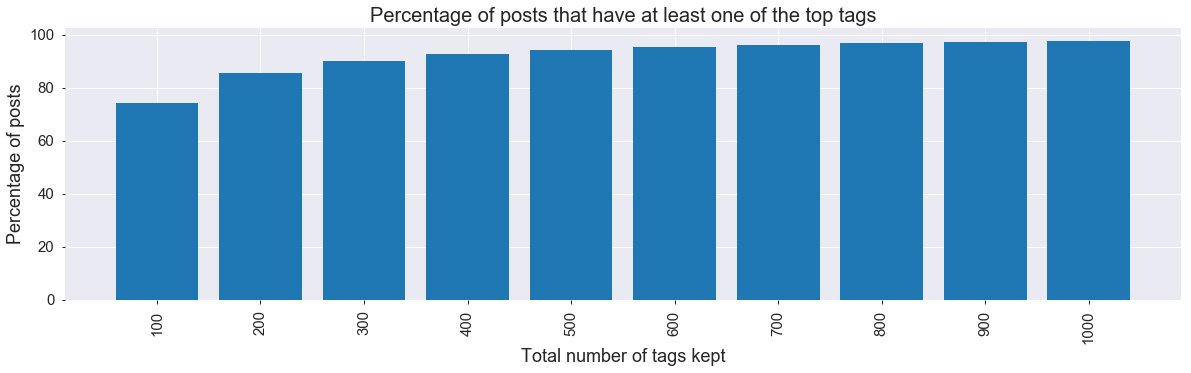

In [14]:
# Graphique représentant le pourcentage de posts qui ont au moins un des top tags

plt.figure(figsize=(20, 5))
y_axis = [nb_posts_targeted[i]/posts_tags.shape[0]*100 for i in np.arange(100,1100, 100)]
label_x = [str(i) for i in np.arange(100,1100, 100)]
ax = plt.axes()
plt.bar(label_x, y_axis)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.title("Percentage of posts that have at least one of the top tags",fontsize=20)
plt.xlabel('Total number of tags kept', fontsize=18)
plt.ylabel('Percentage of posts', fontsize=18)
plt.show()

### Nombre de posts impactés par les 10 à 100 premiers tags

In [15]:
nb_posts_targeted = dict() 

for nb_top_tags in np.linspace(10, 100, 10, dtype='int'):

    top_tags = [i[0] for i in alltags_count[1:nb_top_tags+1]]
    nb_posts_targeted[nb_top_tags] = 0
    
    for _tags in posts_tags.str.split('>'):
        _tags.remove('')
        _tags = [_tag[1:] for _tag in _tags]        
        for _tag in _tags:
            if _tag in top_tags:
                nb_posts_targeted[nb_top_tags] += 1
                break

    percentage_posts = (nb_posts_targeted[nb_top_tags]/posts_tags.shape[0])*100
    print('With %d tags kept, %.2f %% of the posts are concerned ' % (nb_top_tags, percentage_posts))                        

With 10 tags kept, 32.79 % of the posts are concerned 
With 20 tags kept, 41.04 % of the posts are concerned 
With 30 tags kept, 53.19 % of the posts are concerned 
With 40 tags kept, 60.47 % of the posts are concerned 
With 50 tags kept, 62.75 % of the posts are concerned 
With 60 tags kept, 64.43 % of the posts are concerned 
With 70 tags kept, 67.63 % of the posts are concerned 
With 80 tags kept, 69.66 % of the posts are concerned 
With 90 tags kept, 72.50 % of the posts are concerned 
With 100 tags kept, 74.32 % of the posts are concerned 


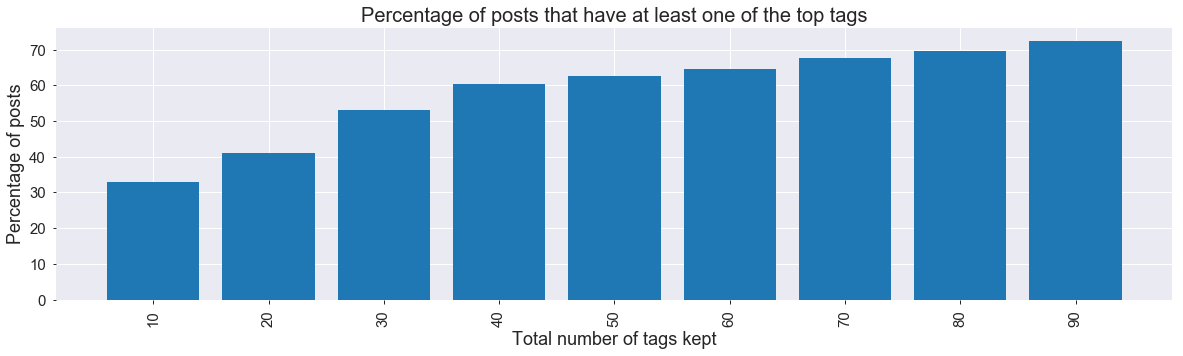

In [16]:
# Graphique représentant le pourcentage de posts qui ont au moins un des top tags

plt.figure(figsize=(20, 5))
y_axis = [nb_posts_targeted[i]/posts_tags.shape[0]*100 for i in np.arange(10,100, 10)]
label_x = [str(i) for i in np.arange(10,100, 10)]
ax = plt.axes()
plt.bar(label_x, y_axis)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.title("Percentage of posts that have at least one of the top tags",fontsize=20)
plt.xlabel('Total number of tags kept', fontsize=18)
plt.ylabel('Percentage of posts', fontsize=18)
plt.show()

In [17]:
def most_common_tags(tags, top_tags, n_tags):
    ''' keep only the tags that are part of the top most used tags on StackOverflow
        filtered tags are sorted by order of appearance in top_tags list

    tags: tags associated to post
    top_tags: most_commonn tags
    n_tags: number of tags by sample
    '''
    
    clean_tags = tags.split('>')
    clean_tags.remove('')
    clean_tags = [_tag[1:] for _tag in clean_tags]     
    tags_filtered = []
    
    for _tag in clean_tags:
        if _tag in top_tags: 
            index = top_tags.index(_tag)
            tags_filtered.insert(index,_tag)    
    
    tags_filtered = tags_filtered[:n_tags]
    
    return tags_filtered

Je ne vais conserver qu'un nombre réduit de tags, d'une part, parce que c'est plus facile de prédire le bon tag à partir d'un nombre réduit de mots ; d'autre part, parce que dans les 10 000 tags, certains sont extrêmement confidentiels et spécifiques

### Top 100 tags = 74% des posts impactés
### Aucune limitation sur le nombre de tags par post

In [18]:
top100tags = [i[0] for i in alltags_count[1:101]]

print("Nombre de posts avant : {0}".format(posts_tags.shape[0]))

posts_top100tags = posts_tags.copy()
posts_top100tags = posts_top100tags.apply(lambda x: most_common_tags(x, top100tags, 5))
posts_top100tags = posts_top100tags.apply(lambda x: x if len(x)>0 else None)
posts_top100tags.dropna(inplace=True)

print('Nombre de posts après : {0}'.format(posts_top100tags.shape[0]))

Nombre de posts avant : 55598
Nombre de posts après : 41322


#### Fréquence des tags conservés 

In [19]:
toptags_count = [i[1] for i in alltags_count[1:101]]
toptags_count = pd.Series(toptags_count / sum(toptags_count) * 100, index=top100tags)
toptags_count.apply(lambda x: "{0:.2f}%".format(x))

c                18.82%
m                10.21%
d                9.44% 
io               3.82% 
j                3.75% 
.net             3.12% 
nt               2.77% 
c#               2.21% 
java             2.14% 
sql              1.95% 
ip               1.63% 
il               1.52% 
vi               1.52% 
em               1.17% 
asp.net          1.09% 
el               1.06% 
c++              1.04% 
rm               0.95% 
ml               0.94% 
int              0.92% 
ca               0.89% 
orm              0.85% 
su               0.82% 
python           0.81% 
sh               0.76% 
javascript       0.75% 
sql-server       0.68% 
window           0.64% 
windows          0.62% 
com              0.62% 
php              0.60% 
visual-studio    0.57% 
ase              0.55% 
ruby             0.53% 
ls               0.53% 
id               0.53% 
pi               0.50% 
html             0.49% 
sta              0.48% 
base             0.47% 
gin              0.44% 
database        

#### Nombre de tags par post et fréquence

In [20]:
from sklearn.preprocessing import MultiLabelBinarizer
# Binarizing the tags for the supervised models
multilabel_binarizer = MultiLabelBinarizer()
Y = multilabel_binarizer.fit_transform(posts_top100tags)
Y_sum = np.sum(Y,axis=1)
import collections
print([*collections.Counter(Y_sum).values()])
print([*collections.Counter(Y_sum).keys()])
print(Y.shape)

[26636, 11975, 2455, 244, 12]
[1, 2, 3, 4, 5]
(41322, 100)


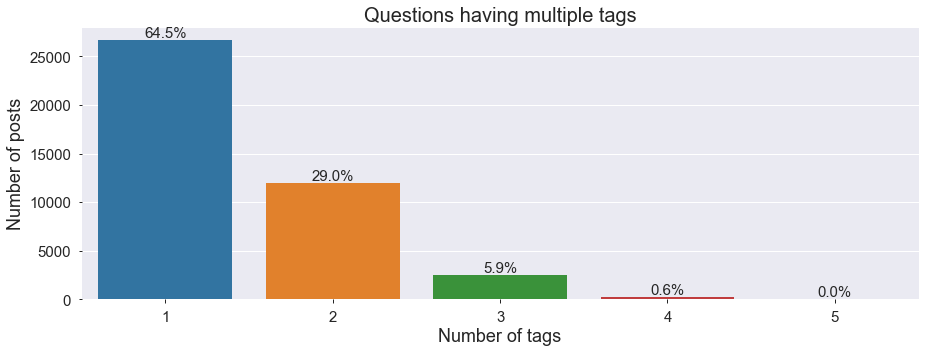

In [21]:
# Nombre de tags par document
Y_n_tags = np.sum(multilabel_binarizer.fit_transform(posts_top100tags),axis=1)
# Fréquence du nombre de tags par document
import collections
multiLabel_counts = collections.Counter(Y_n_tags)
# clés 
# print([x[0] for x in multiLabel_counts.most_common()])
# valeurs 
# print([x[1] for x in multiLabel_counts.most_common()])
plt.figure(figsize=(15,5)) 
ax = sns.barplot([x[0] for x in multiLabel_counts.most_common()], [x[1] for x in multiLabel_counts.most_common()])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Questions having multiple tags",fontsize=20)
plt.xlabel('Number of tags', fontsize=18)
plt.ylabel('Number of posts', fontsize=18)
#adding the text labels
rects = ax.patches
labels = [x[1] for x in multiLabel_counts.most_common()] / np.sum([x[1] for x in multiLabel_counts.most_common()]) 
labels = ["{:0.1%}".format(x) for x in labels]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=15)
plt.show()

### Limitation à 3 tags par post

In [22]:
print("Nombre de posts avant : {0}".format(posts_tags.shape[0]))

posts_top100tags_3labels = posts_tags.copy()
posts_top100tags_3labels = posts_top100tags_3labels.apply(lambda x: most_common_tags(x, top100tags, 3))
posts_top100tags_3labels = posts_top100tags_3labels.apply(lambda x: x if len(x)>0 else None)
posts_top100tags_3labels.dropna(inplace=True)

print('Nombre de posts après : {0}'.format(posts_top100tags_3labels.shape[0]))

Nombre de posts avant : 55598
Nombre de posts après : 41322


#### Fréquence des tags conservés 

In [23]:
# je recompte les occurrences de chaque tag vu que j'en ai réduit le nombre
alltags_count_reduced = dict()
for s in top100tags: 
    alltags_count_reduced[s] = posts_top100tags_3labels.apply(lambda x: ','.join(map(str, x))).str.count(re.escape(s)).sum() 
alltags_count_reduced = sorted(alltags_count_reduced.items(), key=lambda x: x[1], reverse=True)    
toptags_count = [i[1] for i in alltags_count_reduced]
toptags_count = pd.Series(toptags_count / sum(toptags_count) * 100, index=top100tags)
toptags_count.apply(lambda x: "{0:.2f}%".format(x))

c                14.65%
m                7.15% 
d                6.37% 
io               5.92% 
j                5.59% 
.net             5.48% 
nt               3.60% 
c#               2.82% 
java             2.79% 
sql              2.60% 
ip               2.53% 
il               2.01% 
vi               1.99% 
em               1.69% 
asp.net          1.62% 
el               1.62% 
c++              1.55% 
rm               1.37% 
ml               1.33% 
int              1.11% 
ca               1.09% 
orm              1.04% 
su               0.95% 
python           0.92% 
sh               0.89% 
javascript       0.85% 
sql-server       0.85% 
window           0.84% 
windows          0.84% 
com              0.84% 
php              0.84% 
visual-studio    0.82% 
ase              0.81% 
ruby             0.77% 
ls               0.77% 
id               0.73% 
pi               0.72% 
html             0.72% 
sta              0.72% 
base             0.71% 
gin              0.71% 
database        

In [24]:
from sklearn.preprocessing import MultiLabelBinarizer
# Binarizing the tags for the supervised models
multilabel_binarizer = MultiLabelBinarizer()
Y = multilabel_binarizer.fit_transform(posts_top100tags_3labels)
Y_sum = np.sum(Y,axis=1)
import collections
print([*collections.Counter(Y_sum).values()])
print([*collections.Counter(Y_sum).keys()])
print(Y.shape)

[26636, 11975, 2711]
[1, 2, 3]
(41322, 100)


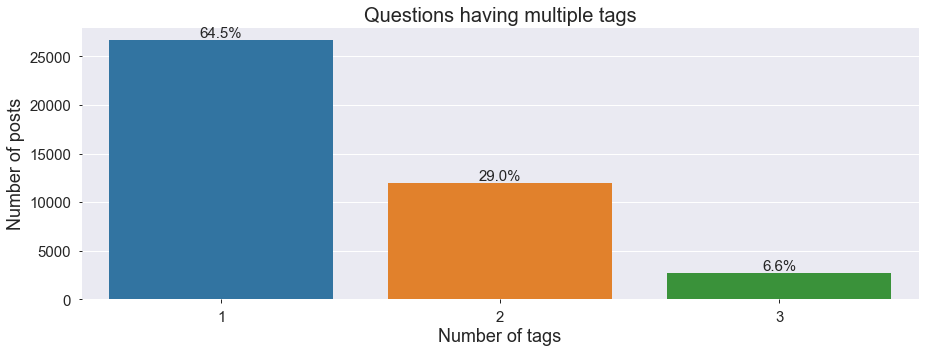

In [25]:
from sklearn.preprocessing import MultiLabelBinarizer
# Binarizing the tags for the supervised models
multilabel_binarizer = MultiLabelBinarizer()
# Nombre de tags par document
Y_n_tags = np.sum(multilabel_binarizer.fit_transform(posts_top100tags_3labels),axis=1)
# Fréquence du nombre de tags par document
import collections
multiLabel_counts = collections.Counter(Y_n_tags)
# clés 
# print([x[0] for x in multiLabel_counts.most_common()])
# valeurs 
# print([x[1] for x in multiLabel_counts.most_common()])
plt.figure(figsize=(15,5)) 
ax = sns.barplot([x[0] for x in multiLabel_counts.most_common()], [x[1] for x in multiLabel_counts.most_common()])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Questions having multiple tags",fontsize=20)
plt.xlabel('Number of tags', fontsize=18)
plt.ylabel('Number of posts', fontsize=18)
#adding the text labels
rects = ax.patches
labels = [x[1] for x in multiLabel_counts.most_common()] / np.sum([x[1] for x in multiLabel_counts.most_common()]) 
labels = ["{:0.1%}".format(x) for x in labels]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=15)
plt.show()

In [27]:
# SAUVEGARDE
top500tags = [i[0] for i in alltags_count[1:101]]
with open('top500tags.pkl', 'wb') as f:    
    pickle.dump(top500tags, f)
    
posts_body.to_pickle("./posts_body.pkl")
posts_top100tags.to_pickle("./posts_top100tags.pkl")
posts_top100tags_3labels.to_pickle("./posts_top100tags_3labels.pkl")

In [27]:
# CHARGEMENT
with open('top500tags.pkl', 'rb') as f:
    top500tags = pickle.load(f)    

posts_body = pd.read_pickle('./posts_body.pkl')
posts_top100tags = pd.read_pickle('./posts_top100tags.pkl')
posts_top100tags_3labels = pd.read_pickle("./posts_top100tags_3labels.pkl")

# Nettoyage du jeu de données

- Suppression des postes dont le score est inférieur à 3
- Suppression du format html avec le package Beautiful Soup 
- Mise en minuscules du texte 
- Transformations des abréviations
- Suppression des stop words proposés par les modules NLP
- Lemmatisation
- Suppression des verbes et adjectifs qui n'apportent de valeur ajoutée pour ce que je souhaite faire
- Suppression de stop words manuels

In [28]:
few_posts = resample(posts_body, n_samples=10, random_state=0)

In [29]:
def clean_text(text):
    ''' Lowering text and removing undesirable marks
    Parameter:
    text: corpus to clean
    '''

    
    text = text.lower()
    text = re.sub(r"\'\n", " ", text) # removes line feeds
    text = re.sub(r"\'\xa0", " ", text) # removes spaces
    text = re.sub('\s+', ' ', text) # matches all whitespace characters : \t\n\r\f\v
    text = text.strip(' ') # removes leading and trailing blanks
    return text

In [30]:
posts_body_clean1 = posts_body.apply(lambda x: clean_text(x))

# the text of the post, without tags or markup
posts_body_clean2 = posts_body_clean1.apply(lambda x: BeautifulSoup(x).get_text())

In [31]:
# avant nettoyage
posts_body_clean1.loc[few_posts.index].sort_index()

3160     <p>what are some real world places that call for delegates? i'm curious what situations or patterns are present where this method is the best solution. no code required.</p>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [32]:
# après nettoyage
posts_body_clean2.loc[few_posts.index].sort_index()

3160     what are some real world places that call for delegates? i'm curious what situations or patterns are present where this method is the best solution. no code required.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [33]:
nlp = English()
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
spacy_tokenizer = nlp.Defaults.create_tokenizer(nlp)
# Spacy va permettre de gérer ce genre de cas : i'm having issues. 
# Plutôt de renvoyer "i", "m", Spacy va renvoyer "i", "'m"
# tokens = tokenizer("i'm having issues")
punct = punctuation

def clean_punctuation(text, ignore_words=top500tags): 
    ''' Remove punctuation
    Parameters:
    text: corpus to remove punctuation from it
    ignore_words: list of words to include without processing them
    '''
    
    
    words = spacy_tokenizer(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    
    for w in words:
        # certains mots peuvent être des tags qui contiennent des signes de ponctuation, il faut les conserver tels quels
        # en utilisant une liste de top tags la plus exhaustive possible
        if str(w) in ignore_words: 
            punctuation_filtered.append('<' + str(w) + '>')
        else:
            w = re.sub('[0-9]', ' ', str(w)) # word contains no digits
            punctuation_filtered.append(regex.sub(' ', str(w)))
        
    result = ' '.join(punctuation_filtered)
    result = re.sub(' +', ' ', result) # remove duplicates whitespaces
    return result 

In [34]:
posts_body_clean3 = posts_body_clean2.apply(lambda x: clean_punctuation(x))

In [35]:
# après nettoyage
posts_body_clean3.loc[few_posts.index].sort_index()

3160     what are some real world places that call for delegates i m curious what situations or patterns are present where this method is the best solution no code required                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [36]:
print(posts_body_clean3.loc[posts_body_clean3.str.contains(re.escape('c++'))].head(1))

10    i m having issues getting the <c> sockets <api> to work properly in <c++> on z os although i am including sys socket h i still get compile <time> errors telling me that af inet is not defined am i missing something obvious or is this related to the fact that being on z os makes my problems much more complicated update upon further investigation i discovered that there is an ifdef that i m hitting apparently z os is n t happy unless i define which type of sockets i m using with define oe sockets now i personally have no idea what this oe sockets is actually for so if any z os sockets programmers are out there all of you perhaps you could give me a rundown of how this all works test app include sys socket h <int> main return af inet compile link output cxx wc xplink wl xplink o inet test inet c inet c line ccn s the name lookup for af inet did not find a declaration ccn i compilation failed for <file> inet c <object> <file> not created a check of sys sockets h does include the defi

In [37]:
def stopWordsRemove(text, stop_words):
    ''' Removing all the english stop words from a corpus
    Parameter:
    text: corpus to remove stop words from it
    stop_words: list of stop words to exclude
    '''

    
    words = spacy_tokenizer(text)
    filtered = [str(w) for w in words if not str(w) in stop_words]
    text = ' '.join(map(str, filtered))
    result = re.sub(' +', ' ', text) # remove duplicates whitespaces
    return result

# no recognition of dependency labels and named entities 
nlp = spacy.load('en', disable=['parser', 'ner'])
print(nlp.pipe_names)

def lemmatization(text_in, allowed_postags, ignore_words=top500tags):
    ''' It keeps the lemma of the words (lemma is the uninflected form of a word),
    and deletes the undesired POS tags
    
    Parameters:
    
    text_in (list): text to lemmatize
    allowed_postags (list): list of allowed postags, like NOUN, ADJ, VERB, ADV
    ignore_words: list of words to include without processing them
    '''

    
    doc = nlp(text_in) 
    text_out = []
    
    for token in doc:
        
        if str(token) in ignore_words:
            text_out.append(str(token))
            
        elif token.pos_ in allowed_postags:            
            text_out.append(token.lemma_)
                
    text_out = ' '.join(text_out)
    result = re.sub(' +', ' ', text_out) # remove duplicates whitespaces

    return result

['tagger']


Il y a pas mal de mots (ex: like, use, get, new) qui n'apportent aucune information pertinente sur le contenu de la question. 

Je me focalise donc sur les noms essentiellement. 

In [38]:
auto_stopwords = set(set(nlp.Defaults.stop_words) | set(stopwords.words("english")))
posts_body_clean4 = posts_body_clean3.apply(lambda x: stopWordsRemove(x, auto_stopwords)) 
posts_body_clean5 = posts_body_clean4.apply(lambda x: lemmatization(x, ['NOUN']))

In [39]:
# après nettoyage
posts_body_clean5.loc[few_posts.index].sort_index()

3160     world place situation pattern method solution code                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
35063    concept javascript time question javascript language .net runtime .net platform compiler language compiler c output compiler compiler generate output source build operation output compiler process question detail process script doc thing language design compilation advantage concept people concept edit thank information research question compiler run source time type output sc

In [40]:
print(posts_body_clean5.loc[posts_body_clean5.str.contains(re.escape('c++'))].head(1))

10    issue c api work c++ compile time error fact problem update investigation ifdef define type socket socket socket work app int return inet compile link output cxx c c line declaration compilation file inet c object file check socket definition ifdef statement ifdef cplusplus c encapsulate file matter
Name: Body, dtype: object


In [41]:
#doc = nlp("successfully")
#for token in doc:
#    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop)

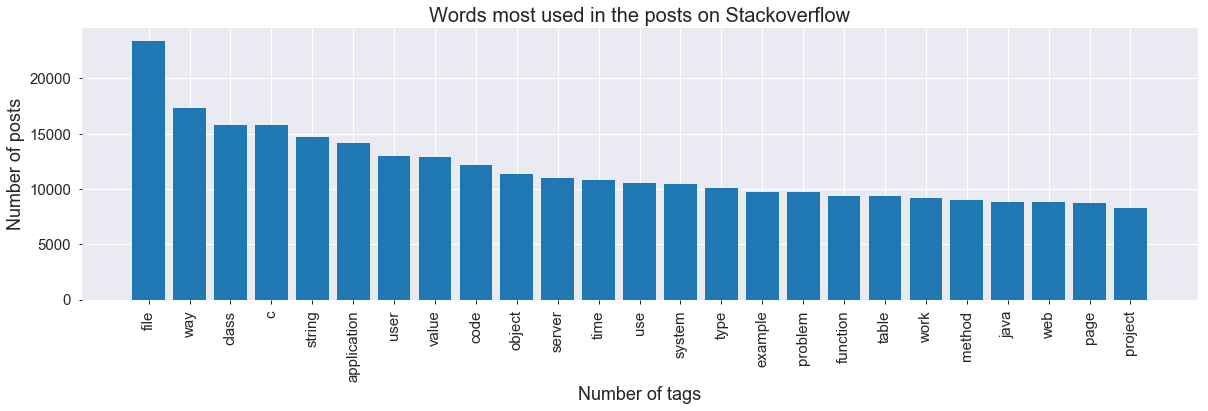

In [42]:
# Graph showing the words most used in the post on Stackoverflow

txt = posts_body_clean5.str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)
result = pd.DataFrame(word_dist.most_common(25),columns=['Word','Frequency'])

plt.figure(figsize=(20, 5))
plt.xlabel('Number of tags', fontsize=18)
plt.ylabel('Number of posts', fontsize=18)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.bar(result.Word, result.Frequency)
plt.title("Words most used in the posts on Stackoverflow",fontsize=20)
plt.show()

In [43]:
result = pd.DataFrame(word_dist.most_common(200),columns=['Word','Frequency'])
display(result)

,Word,Frequency
0,file,23407
1,way,17325
2,class,15835
3,c,15779
4,string,14719
5,application,14131
6,user,12954
7,value,12918
8,code,12161
9,object,11330


Dans le lot, il y a des mots "fourre-tout" que j'intègre aux stopwords et je réapplique la fonction de suppression des stopwords. 

In [44]:
manual_stopwords = ['file', 'way', 'application', 'user', 'use', 'method',
                    'example', 'problem', 'work', 'test', 'question', 'project', 'thank',
                    'return', 'solution', 'thing', 'change', 'program', 'idea', 'end',
                    'message', 'result', 'answer', 'issue', 'language', 'information',
                    'document', 'e', 'default', 'help', 'people', 'run', 'testing',
                    'difference', 'stuff', 'need', 'response', 'check', 'product', 'approach', 
                    'want', 'suggestion', 'n', 'custom', 'create', 'p', 'place', 'comment',
                    'support', 'person', 'expression']

manual_stopwords = set(manual_stopwords)
posts_body_clean5 = posts_body_clean5.apply(lambda x: stopWordsRemove(x, manual_stopwords)) 

In [45]:
print(posts_body_clean5.loc[posts_body_clean5.str.contains(re.escape('c++'))].head(1))

10    c api c++ compile time error fact update investigation ifdef define type socket socket socket app int inet compile link output cxx c c line declaration compilation inet c object socket definition ifdef statement ifdef cplusplus c encapsulate matter
Name: Body, dtype: object


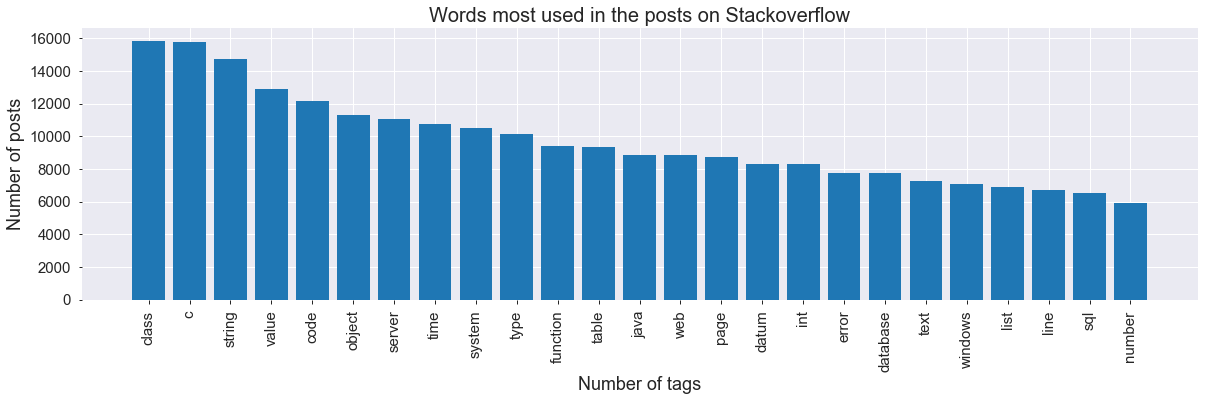

In [46]:
# Graph showing the words most used in the post on Stackoverflow

txt = posts_body_clean5.str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)
result = pd.DataFrame(word_dist.most_common(25),columns=['Word','Frequency'])

plt.figure(figsize=(20, 5))
plt.xlabel('Number of tags', fontsize=18)
plt.ylabel('Number of posts', fontsize=18)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.bar(result.Word, result.Frequency)
plt.title("Words most used in the posts on Stackoverflow",fontsize=20)
plt.show()

In [47]:
# SAUVEGARDE
posts_body_clean5.to_pickle("./posts_body_clean5.pkl")

In [ ]:
# CHARGEMENT
with open('top500tags.pkl', 'rb') as f:
    top500tags = pickle.load(f)    

posts_body = pd.read_pickle('./posts_body.pkl')
posts_top100tags = pd.read_pickle('./posts_top100tags.pkl')
posts_top100tags_3labels = pd.read_pickle("./posts_top100tags_3labels.pkl")
posts_body_clean5 = pd.read_pickle("./posts_body_clean5.pkl")

# Préparation des données pour modélisation

### Scénario top 100 tags et 3 tags par post

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

In [49]:
# Liste des caractères distincts de la liste top500tags
''.join(set().union(*top500tags))

'#ljy.nemg-oxdt+afwphsubcrvqi'

In [90]:
s = 'c++'
reg = r'(?u)\S+'
re.match(reg, s)

<re.Match object; span=(0, 3), match='c++'>

In [191]:
def model_preprocessing(tags, body):
    
    # Binarizing the tags for the supervised models
    mlb = MultiLabelBinarizer()
    Y_target = mlb.fit_transform(tags)
    
    # 80/20 split
    X_train, X_test, Y_train, Y_test = train_test_split(body.loc[tags.index], 
                                                        Y_target, 
                                                        test_size=0.2, train_size=0.8, random_state=42)
    
    tfidf = TfidfVectorizer(analyzer='word', 
                            encoding='utf-8', 
                            token_pattern=r'(?u)\S+', 
                            max_features=500)
    
    # TF-IDF matrices
    # la littérature recommande de ne pas standardiser un TDIDF
    X_tfidf_train = tfidf.fit_transform(X_train)
    X_tfidf_test = tfidf.transform(X_test)

    return mlb, tfidf, X_tfidf_train, Y_train, X_tfidf_test, Y_test

In [192]:
mlb, tfidf, X_tfidf_train, Y_train, X_tfidf_test, Y_test = model_preprocessing(posts_top100tags_3labels, posts_body_clean5)

In [193]:
tfidf.get_feature_names()

['.net',
 'ability',
 'access',
 'account',
 'action',
 'address',
 'advantage',
 'advice',
 'age',
 'alert',
 'algorithm',
 'alternative',
 'api',
 'app',
 'append',
 'area',
 'arg',
 'argument',
 'array',
 'article',
 'asp.net',
 'aspx',
 'assembly',
 'attempt',
 'attribute',
 'authentication',
 'author',
 'auto',
 'avoid',
 'b',
 'background',
 'bar',
 'base',
 'behavior',
 'benefit',
 'bit',
 'block',
 'blog',
 'body',
 'book',
 'boost',
 'border',
 'box',
 'branch',
 'break',
 'browser',
 'buffer',
 'bug',
 'build',
 'building',
 'business',
 'button',
 'byte',
 'c',
 'c++',
 'call',
 'callback',
 'car',
 'card',
 'case',
 'catch',
 'category',
 'cause',
 'cell',
 'character',
 'child',
 'choice',
 'class',
 'click',
 'client',
 'code',
 'collection',
 'color',
 'column',
 'com',
 'combination',
 'command',
 'company',
 'compile',
 'compiler',
 'component',
 'computer',
 'concept',
 'condition',
 'config',
 'configuration',
 'connection',
 'console',
 'constraint',
 'constructor',

# Recommandation de tags
### Approche non supervisée

In [194]:
from sklearn.decomposition import LatentDirichletAllocation

In [195]:
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

Extracting topics from LDA...


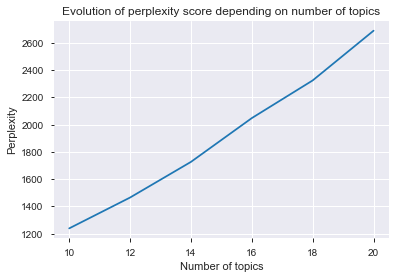

In [201]:
best_perplexity = np.inf
best_lda = 0
perplexity_list = []
n_topics_list = []
lda_model_list = []

print("Extracting topics from LDA...")

# number of topics 
for n_topics in np.linspace(10, 20, 6, dtype='int'):
    lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5, n_jobs=-1, random_state=42).fit(X_tfidf_train)
    n_topics_list.append(n_topics)
    perplexity = lda_model.perplexity(X_tfidf_test)
    perplexity_list.append(perplexity)
    lda_model_list.append(lda_model)

    # Perplexity is defined as exp(-1. * log-likelihood per word)
    # Perplexity: The smaller the better
    if perplexity <= best_perplexity:
        best_perplexity = perplexity
        best_lda = lda_model
                                
plt.title("Evolution of perplexity score depending on number of topics")
plt.xlabel("Number of topics")
plt.ylabel("Perplexity")
plt.plot(n_topics_list, perplexity_list)
plt.show()

In [202]:
n_top_words = 10
display_topics(lda_model_list[4], tfidf.get_feature_names(), n_top_words)

Topic 0:
svn directory server folder repository machine path client subversion windows
Topic 1:
library window wpf algorithm c studio windows time ide c++
Topic 2:
string value character list c word length number space text
Topic 3:
table column row date record value field sql database time
Topic 4:
item text class container object extension list type var element
Topic 5:
php ruby email session script rail mail server icon time
Topic 6:
sql database server mysql table procedure datum query xml statement
Topic 7:
int class function c type value object foo self member
Topic 8:
.net service web windows config api framework c app server
Topic 9:
form view action forms controller context post control button page
Topic 10:
c c++ asp.net control code source book studio dialog resource
Topic 11:
object system assembly collection class type instance reference xml version
Topic 12:
unit tool list child task element parent code time class
Topic 13:
java thread class property jar model object libr

In [203]:
# SAUVEGARDE
with open('lda_model_list.pkl', 'wb') as f:
    pickle.dump(lda_model_list, f)

In [ ]:
#0 interface graphique
#1 programmation objet (base)
#2 back end
#3 ?
#4 ?
#5 développement web
#6 programmation objet (interface)
#7 scripting
#8 développement HTML
#9 requêtage database

In [96]:
#import pyLDAvis.sklearn 
#pyLDAvis.enable_notebook()
#panel = pyLDAvis.sklearn.prepare(best_lda, X_tfidf_test_top100tags, tfidf_top100tags, mds='tsne')
#panel

# Approche supervisée

In [97]:
# CHARGEMENT
with open('lda_model_list.pkl', 'rb') as f:
    best_lda = pickle.load(f)    
with open('top500tags.pkl', 'rb') as f:
    top500tags = pickle.load(f)    

posts_body = pd.read_pickle('./posts_body.pkl')
posts_top100tags = pd.read_pickle('./posts_top100tags.pkl')
posts_top100tags_3labels = pd.read_pickle("./posts_top100tags_3labels.pkl")
posts_body_clean5 = pd.read_pickle("./posts_body_clean5.pkl")

In [140]:
mlb, tfidf, X_tfidf_train, Y_train, X_tfidf_test, Y_test = model_preprocessing(posts_top100tags_3labels, posts_body_clean5)

In [141]:
def n_tags_by_labels(data, data_label):
    # Nombre de tags par document
    Y_n_tags = np.sum(data,axis=1)
    # Fréquence du nombre de tags par document
    import collections
    multiLabel_counts = collections.Counter(Y_n_tags)
    # clés 
    # print([x[0] for x in multiLabel_counts.most_common()])
    # valeurs 
    # print([x[1] for x in multiLabel_counts.most_common()])
    plt.figure(figsize=(15,5))
    ax = sns.barplot([x[0] for x in multiLabel_counts.most_common()], [x[1] for x in multiLabel_counts.most_common()])
    plt.title("Questions having multiple tags : {}".format(data_label), fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)    
    plt.ylabel('Number of questions', fontsize=18)
    plt.xlabel('Number of tags', fontsize=18)
    #adding the text labels
    rects = ax.patches
    labels = [x[1] for x in multiLabel_counts.most_common()] / np.sum([x[1] for x in multiLabel_counts.most_common()]) 
    labels = ["{:0.1%}".format(x) for x in labels]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=15)      
    return 

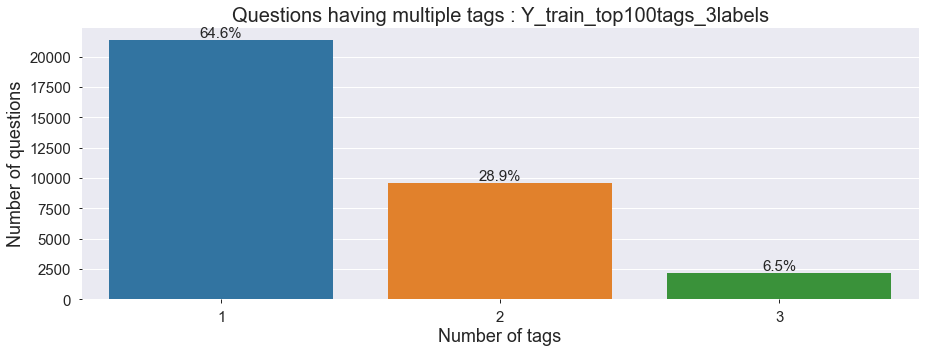

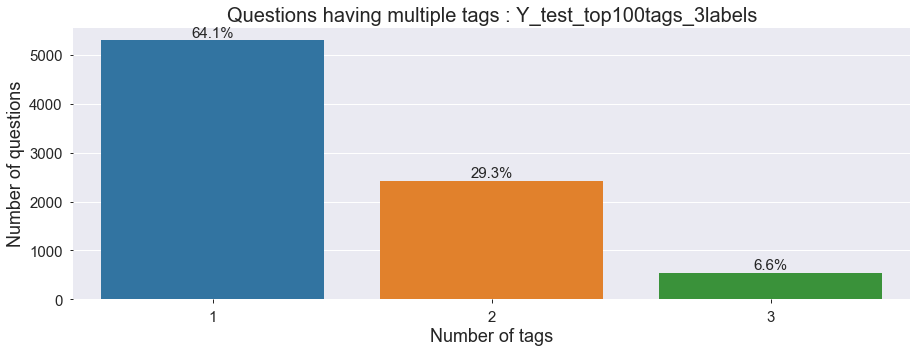

In [142]:
n_tags_by_labels(Y_train, 'Y_train_top100tags_3labels') 
n_tags_by_labels(Y_test, 'Y_test_top100tags_3labels') 

In [204]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import jaccard_score

dummy_clf = OneVsRestClassifier(DummyClassifier(strategy="stratified"))
dummy_clf.fit(X_tfidf_train, Y_train)

Y_pred = dummy_clf.predict(X_tfidf_test)
print(jaccard_score(Y_test, Y_pred, average='weighted'))

0.03759581376303107


In [206]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(MultinomialNB())

parameters = {
    'estimator__alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'estimator__fit_prior' : [True, False]
}

mnb_top100tags_3labels = GridSearchCV(clf, param_grid=parameters, scoring='jaccard_weighted', n_jobs=-1)
mnb_top100tags_3labels.fit(X_tfidf_train, Y_train)

print (mnb_top100tags_3labels.best_params_, mnb_top100tags_3labels.best_score_)

{'estimator__alpha': 0.001, 'estimator__fit_prior': False} 0.2224633099462085


In [153]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42))

parameters = {
    'estimator__penalty': ['l1', 'l2'], 
    'estimator__C': [0.1, 1, 10, 100, 1000], 
    'estimator__class_weight': ['balanced', None]
}

lr_top100tags_3labels = GridSearchCV(clf, param_grid=parameters, scoring='jaccard_weighted', n_jobs=-1)
lr_top100tags_3labels.fit(X_tfidf_train, Y_train)

print (lr_top100tags_3labels.best_params_, lr_top100tags_3labels.best_score_)

{'estimator__C': 10, 'estimator__class_weight': None, 'estimator__penalty': 'l1'} 0.3657843861938672


In [154]:
# SAUVEGARDE
with open('lr_top100tags_3labels.pkl', 'wb') as f:
    pickle.dump(lr_top100tags_3labels, f)

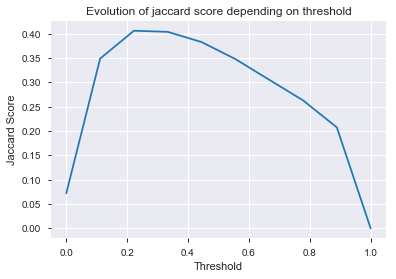

In [208]:
from sklearn.metrics import jaccard_score

jaccard_list = []

for s in np.linspace(0, 1, 10, dtype='float'):

    Y_pred = pd.DataFrame(lr_top100tags_3labels.best_estimator_.predict_proba(X_tfidf_test)).applymap(lambda x:1 if x>s else 0).to_numpy()
    jaccard_list.append(jaccard_score(Y_test, Y_pred, average='weighted'))
                                
plt.title("Evolution of jaccard score depending on threshold")
plt.xlabel("Threshold")
plt.ylabel("Jaccard Score")
plt.plot(np.linspace(0, 1, 10, dtype='float'), jaccard_list)
plt.show()

In [211]:
Y_pred = pd.DataFrame(lr_top100tags_3labels.best_estimator_.predict_proba(X_tfidf_test)).applymap(lambda x:1 if x>0.22 else 0).to_numpy()
Y_true = pd.Series(mlb.inverse_transform(Y_test))
Y_pred = pd.Series(mlb.inverse_transform(Y_pred))
display(pd.concat([Y_true, Y_pred], axis=1)[:20])

,0,1
0,"(.net, c#, winforms)","(.net, c#, winforms)"
1,"(c, java)","(c#, java)"
2,"(performance,)",()
3,"(c#,)","(.net, asp.net, c#)"
4,"(php,)",()
5,"(c#,)","(c, c#)"
6,"(forms, javascript)","(javascript,)"
7,"(.net,)","(.net, c#)"
8,"(php,)",()
9,"(winforms,)","(c#, winforms, wpf)"


# Fonction de recommandation de tags

Recommande des mots issus des analyses supervisées et non supervisées

In [258]:
def Recommend_tags_lda(text_ori, n_words, mlb, tfidf, lda, clf, seuil=0.5, toptags=top500tags, clean=False):
    
    ''' Recommendation system for StackOverflow posts based on a lda model, it returns up to 5 words.

    Parameters:

    text: the stackoverflow post of user
    n_words: number of tags to recommend
    seuil: threshold for decision
    clean: True if data preparation is needed
    '''

    auto_stopwords = set(set(nlp.Defaults.stop_words) | set(stopwords.words("english")))
    manual_stopwords = ['file', 'way', 'application', 'user', 'use', 'method',
                        'example', 'problem', 'work', 'test', 'question', 'project', 'thank',
                        'return', 'solution', 'thing', 'change', 'program', 'idea', 'end',
                        'message', 'result', 'answer', 'issue', 'language', 'information',
                        'document', 'e', 'default', 'help', 'people', 'run', 'testing',
                        'difference', 'stuff', 'need', 'response', 'check', 'product', 'approach', 
                        'want', 'suggestion', 'n', 'custom', 'create', 'p', 'place', 'comment',
                        'support', 'person', 'expression']
    manual_stopwords = set(manual_stopwords)    
    
    if type(text_ori) in (str, pd.Series):
        if type(text_ori) is str:
            text_ori = pd.Series(text_ori) 
        text = text_ori
        text_ori = text_ori.rename("Texte d'origine")
        text = text.rename("Texte modifié")
    else:
        return 'Type should be str or pd.Series'

    if clean==True:
        text = text.apply(lambda x: clean_text(x))
        text = text.apply(lambda x: BeautifulSoup(x).get_text())
        text = text.apply(lambda x: clean_punctuation(x))        
        text = text.apply(lambda x: stopWordsRemove(x, auto_stopwords))
        text = text.apply(lambda x: lemmatization(x, ['NOUN']))   
        text = text.apply(lambda x: stopWordsRemove(x, manual_stopwords))

    # document = question StackOverflow
    # word = il s'agit des mots issus du vocabulaire LDA, retenus par le LDA (max_features)
    # topic = il s'agit des topics issus du LDA (components)
    # pour chaque document et chaque mot, je calcule la probabilité totale qu'un mot apparaisse dans le document 
    # proba(word1) = proba(word1/topic1) * proba(topic1) + proba(word1/topic2) * proba(topic2) ...
    # je conserve les n_tags
    
    document_tfidf = tfidf.transform(text)
    proba_topic_sachant_document = lda.transform(document_tfidf)
    word_labels = tfidf.get_feature_names()
    proba_word_sachant_topic = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis] # normalization    
    #print(proba_topic_sachant_document.shape)    
    #print(proba_word_sachant_topic.shape)    
    
    # proba_topic_sachant_document est de dimension d x t
    # proba_word_sachant_topic est de dimension t x w
    # je peux donc opérer un produit matriciel entre les 2 matrices pour calculer pour chaque document : proba(wordn)
    # j'obtiendrai une matrice proba_word_sachant_document de dimension d x w
    # il ne me restera plus qu'à choisir les "n_words" mots les plus probables
    proba_word_sachant_document = proba_topic_sachant_document.dot(proba_word_sachant_topic)  
    
    # je transforme la matrice en dataframe : 
    # data = les proba des mots pour chaque document
    # index = l'index des données en entrée
    # columns = les labels des mots sélectionnés en sortie du LDA
    df_wd = pd.DataFrame(data=proba_word_sachant_document,
                         index=text.index,
                         columns=word_labels) 
    
    # np.argsort(-df_wd.values, axis=1)[:, :n_words])
    # renvoie pour chaque document, les "n_words" indexes des colonnes dont les proba sont les plus élevées
    # grâce aux indexes, je peux récupérer le libellé de la colonne qui est donc le libellé du mot 
    # et le stocker en ligne
    values = df_wd.columns.values[np.argsort(-df_wd.values, axis=1)[:, :n_words]]
    values = [", ".join(item) for item in values.astype(str)]
    #pred_unsupervised = pd.DataFrame(df_wd.columns.values[np.argsort(-df_wd.values, axis=1)[:, :n_words]],
    #                                 index=df_wd.index,
    #                                 columns = ['word' + str(i + 1) for i in range(n_words)])
    pred_unsupervised = pd.DataFrame(values,
                                     index=df_wd.index,
                                     columns = ['Unsupervised'])
    
    pred_supervised = pd.DataFrame(clf.predict_proba(tfidf.transform(text))).applymap(lambda x:1 if x>seuil else 0).to_numpy()
    pred_supervised = pd.Series(mlb.inverse_transform(pred_supervised), name='Supervised', index=text.index)
    pred_supervised = pred_supervised.apply(lambda row: ', '.join(row))
    result = pd.concat([pred_supervised, pred_unsupervised, text_ori, text], axis=1)
    
    return result

In [263]:
test = "this sql request grouping values by keys on the relational database is not working."
display(Recommend_tags_lda(test, 5, mlb, tfidf, lda_model_list[4], lr_top100tags_3labels.best_estimator_, seuil=0.22, clean=True))

test = "I want to develop a web application generating html, javascript and css, what is the good language to do that."
display(Recommend_tags_lda(test, 5, mlb, tfidf, lda_model_list[4], lr_top100tags_3labels.best_estimator_, seuil=0.22, clean=True))

test = "I want to code a Python function to sum item from a dictionary."
display(Recommend_tags_lda(test, 5, mlb, tfidf, lda_model_list[4], lr_top100tags_3labels.best_estimator_, seuil=0.22, clean=True))

test = posts_body_clean5.loc[2:5]
display(Recommend_tags_lda(test, 5, mlb, tfidf, lda_model_list[4], lr_top100tags_3labels.best_estimator_, seuil=0.22, clean=False))
#test = X_test[:2]

,Supervised,Unsupervised,Texte d'origine,Texte modifié
0,"database, sql","sql, database, server, mysql, table",this sql request grouping values by keys on the relational database is not working.,sql request value key database


,Supervised,Unsupervised,Texte d'origine,Texte modifié
0,"css, html, javascript","page, javascript, html, image, jquery","I want to develop a web application generating html, javascript and css, what is the good language to do that.",web html javascript css


,Supervised,Unsupervised,Texte d'origine,Texte modifié
0,python,"python, item, line, text, iphone",I want to code a Python function to sum item from a dictionary.,python function item


,Supervised,Unsupervised,Texte d'origine,Texte modifié
2,".net, c#","table, sql, database, server, column",datetime birthday calculate age year,datetime birthday calculate age year
3,"c#, time","table, column, row, date, value",datetime value display time hour day month,datetime value display time hour day month
4,asp.net,"page, javascript, html, image, jquery",web server determine timezone web page http header agent string,web server determine timezone web page http header agent string
5,".net, c#",".net, service, web, windows, c",floor math .net,floor math .net


In [167]:
from sklearn import metrics
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [134]:
vectorizer_X = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                               encoding='utf-8',                                
                               max_features=5)

# TF-IDF matrices
X_tfidf_train = vectorizer_X.fit_transform(X_train)
X_tfidf_test = vectorizer_X.transform(X_test)

lda_model = LatentDirichletAllocation(n_components=2, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=42).fit(X_tfidf_train)


proba_topic_sachant_text = lda_model.transform(X_tfidf_test)
feature_names = vectorizer_X.get_feature_names()
proba_tag_sachant_topic = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis] # normalization    
print(proba_topic_sachant_text.shape)
print(proba_tag_sachant_topic.shape)

(8265, 2)
(2, 5)


In [135]:
mult = proba_topic_sachant_text.dot(proba_tag_sachant_topic)
print(mult[0])

[0.18787094 0.21819323 0.16399752 0.14814547 0.28179283]


In [136]:
proba_topic_sachant_text[0]

array([0.5, 0.5])